# I. Easy level

Для начала импортируем всё, что нам пригодится в дальнейшем

In [66]:
from typing import Callable, Tuple, List
from copy import deepcopy
import numpy as np
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split
import math
import random

Реализуем метод Гаусса для приведения заданной матрицы к ступенчатому виду (будем фиксировать изменение определителя, пригодится в дальнейшем)

In [67]:
def gauss(matrix: List[List[float]], epsilon: float = 1e-6) -> Tuple[List[List[float]], int]:
    n = len(matrix)
    m = len(matrix[0]) if n > 0 else 0
    det_sign = 1
    pivot_row = 0
    rank = 0

    for col in range(m):
        # Поиск максимального элемента в столбце (с учетом epsilon)
        max_row = None
        max_val = 0.0
        for row in range(pivot_row, n):
            abs_val = abs(matrix[row][col])
            if abs_val > max_val + epsilon:
                max_val = abs_val
                max_row = row

        if max_row is None:
            continue  # Пропускаем столбец, если все элементы ~0

        # Перестановка строк (если нужно)
        if max_row != pivot_row:
            matrix[pivot_row], matrix[max_row] = matrix[max_row], matrix[pivot_row]
            det_sign *= -1

        pivot_element = matrix[pivot_row][col]
        if abs(pivot_element) <= epsilon:
            continue  # Ведущий элемент слишком мал, пропускаем столбец

        # Зануление элементов ниже ведущего
        for row in range(pivot_row + 1, n):
            current_element = matrix[row][col]
            if abs(current_element) <= epsilon:
                matrix[row][col] = 0.0
                continue

            factor = current_element / pivot_element
            matrix[row][col] = 0.0  # Явное обнуление

            for c in range(col + 1, m):
                matrix[row][c] -= factor * matrix[pivot_row][c]
                if abs(matrix[row][c]) <= max(epsilon / abs(factor), epsilon, epsilon * abs(factor)):
                    matrix[row][c] = 0.0  # Обнуляем маленькие значения

        rank += 1
        pivot_row += 1
        if pivot_row >= n:
            break

    # Финальное зануление всех элементов, меньших epsilon
    for row in range(n):
        for col in range(m):
            if abs(matrix[row][col]) <= epsilon:
                matrix[row][col] = 0.0

    return matrix, det_sign

Дополним его функций поиска ФСР однородной СЛАУ (ведь именно такие впоследствии придется решать)

In [68]:
def find_fsr(matrix: List[List[float]]) -> List[List[float]]:
    n = len(matrix)  # число уравнений
    m = len(matrix[0])  # число переменных

    # Определяем ведущие переменные (первые ненулевые в каждой строке)
    lead_vars = []
    for r in range(n):
        lead = 0
        while lead < m and matrix[r][lead] == 0:
            lead += 1
        if lead < m:
            lead_vars.append(lead)

    # Свободные переменные - все остальные
    free_vars = [j for j in range(m) if j not in lead_vars]
    k = len(free_vars)  # размерность ФСР

    if k == 0:
        return []  # только нулевое решение

    # Строим ФСР
    fsr = []
    for free in free_vars:
        solution = [0.0] * m
        solution[free] = 1.0  # Присваиваем свободной переменной 1

        # Выражаем базисные переменные через свободные
        for r in reversed(range(len(lead_vars))):  # Обратный порядок!
            lead = lead_vars[r]
            if lead < m:
                # Суммируем только по переменным справа от ведущей
                solution[lead] = -sum(matrix[r][j] * solution[j]
                                      for j in range(lead + 1, m))

        fsr.append(solution)

    return fsr

Вспомогательные функции - транспонирование матрицы, получение колонки значений, перемножение матриц, получение следа матрицы, нормализация вектора

In [69]:
def transpose(X: List[List[float]]) -> List[List[float]]:
    XT = [[X[j][i] for j in range(len(X))] for i in range(len(X[0]))]
    return XT


def get_col(X: List[List[float]], n: int) -> List[float]:
    return [e[n] for e in X]


def matrix_multiplication(X: List[List[float]], Y: List[List[float]]) -> List[List[float]]:
    if len(X[0]) != len(Y):
        raise ValueError('Невозмножно перемножить матрицы данной размерности.')
    M = [[0 for i in range(len(Y[0]))] for j in range(len(X))]
    for i in range(len(X)):
        for j in range(len(Y[0])):
            M[i][j] = sum([X[i][k] * get_col(Y, j)[k] for k in range(len(X[0]))])
    return M


def normalize(vec):
    norm = sum(e**2 for e in vec) ** 0.5
    nvec = [e/norm for e in vec]
    return nvec


def get_trace(A):
    trace = sum([A[i][i] for i in range(len(A))])
    return trace

Две функции: взятие среднего по каждому столбцу и центрирование матрицы

In [70]:
def mean(X: List[List[float]]) -> List[float]:
    v = [sum(get_col(X, i)) / len(X) for i in range(len(X[0]))]
    return v


def center_data(X: List[List[float]]) -> List[List]:
    vec_mean = mean(X)
    for i in range(len(X)):
        for j in range(len(X[0])):
            X[i][j] -= vec_mean[j]
    return X

Считаем матрицу ковариаций

In [71]:
def covariance_matrix(X_centered: List[List[float]]) -> List[List[float]]:
    n = len(X_centered)
    C = matrix_multiplication(transpose(X_centered), X_centered)
    for i in range(len(C[0])):
        for j in range(len(C[0])):
            C[i][j] /= (n - 1)
    return C

# II. Normal level

Переносим наработки с лабы по матану: поиск экстремумов и корней неявно заданной функции методом дихотомии

In [72]:
def dichotomy_method(a: float, b: float, epsilon: float, matrix: List[List],
                     f: Callable[[List[List], float], float]) -> float:
    delta = epsilon / 2
    while (b - a) > epsilon:
        y = (a + b - delta) / 2
        z = (a + b + delta) / 2
        if f(matrix, y) <= f(matrix, z):
            b = z
        else:
            a = y
    x_min = (a + b) / 2
    return x_min


def solver(f: Callable[[List[List], float], float], matrix, a: float, b: float, epsilon: float) -> Tuple[float, int]:
    # Проверка знаков функции на концах отрезка
    if f(matrix, a) * f(matrix, b) > 0:
        res = dichotomy_method(a, b, epsilon, matrix, f)

        # Проверяем, есть ли корень на отрезке, иначе выбрасываем ничего
        if any([f(matrix, res) * f(matrix, a) <= 0, f(matrix, res - epsilon / 2) * f(matrix, a) <= 0,
                f(matrix, res + epsilon / 2) * f(matrix, a) <= 0]):
            return solver(f, matrix, a, res, epsilon)
        return

    # Критерий остановки: если разница между концами отрезка меньше погрешности
    if abs(b - a) < epsilon:
        return (a + b) / 2

    # Вычисляем середины отрезка с учетом погрешности
    a1, b1 = (a + b - epsilon / 2) / 2, (a + b + epsilon / 2) / 2

    # Определяем, какой из отрезков выбрать для дальнейшего поиска корня
    tup = (a1, b) if f(matrix, a1) * f(matrix, a) > 0 else (a, b1)

    return solver(f, matrix, *tup, epsilon)

Ищем значение характеристического многочлена в заданной точке через Гаусса и посчет определителя

In [73]:
def char_polinom_value(matrix: List[List[float]], x: float) -> float:
    a = [[matrix[i][j] if i != j else matrix[i][i] - x for j in range(len(matrix[0]))] for i in range(len(matrix))]
    gauss_matrix, multiplier = gauss(a)
    result = 1
    for i in range(len(a)):
        result *= gauss_matrix[i][i]
    return result * multiplier

Ищем кол-во собственных значений слева от заданной точки. используя $LDL^T$ разложение матрицы, $L$ - нижнетреугольная матрица, $D$ - диагональная.

In [74]:
def ldlt_count_full(C: List[List[float]], x: float, eps: float = 1e-6) -> int:
    n = len(C)
    A = [[C[i][j] if i != j else C[i][i] - x for j in range(n)] for i in range(n)]
    L = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    D = [0 for _ in range(n)]
    for k in range(n):
        sum_LDL = sum(L[k][j] ** 2 * D[j] for j in range(k))
        Dk = A[k][k] - sum_LDL
        Dk = Dk if abs(Dk) > eps else eps
        D[k] = Dk
        for i in range(k + 1, n):
            sum_LDL = sum(L[i][j] * L[k][j] * D[j] for j in range(k))
            L[i][k] = (A[i][k] - sum_LDL) / Dk
    return sum(1 if e < 0 else 0 for e in D)

С помощью вышеописанной функции локализуем корни, находя промежутки, в которых находятся только лишь они - и запускаем solver для каждого из промежутка, то есть пользуемся бисекцией

In [75]:
def localize_eigenvalues(matrix: List[List[float]], a: float, b: float) -> List[Tuple[float, float]]:
    stack = [(a, b)]
    fstack = []
    while stack:
        a_curr, b_curr = stack.pop()
        und_a = ldlt_count_full(matrix, a_curr)
        und_b = ldlt_count_full(matrix, b_curr)
        n_roots = und_b - und_a
        if n_roots == 0:
            continue
        if n_roots == 1:
            fstack.append((a_curr, b_curr))
        else:
            mid = (a_curr + b_curr) / 2
            stack.append((a_curr, mid))
            stack.append((mid, b_curr))
    return fstack


def find_eigenvalues(matrix: List[List[float]], tol=1e-6) -> List[float]:
    a, b = 0, get_trace(matrix)
    fstack = localize_eigenvalues(matrix, a, b)
    eigenvalues = []
    for section in fstack:
        root = solver(char_polinom_value, matrix, section[0], section[1], tol)
        eigenvalues.append(root)
    return eigenvalues

Находим собственные вектора через решение СЛАУ вида $A - \lambda I$ для всех $\lambda$

In [76]:
def find_sorted_eigenvectors(matrix: List[List[float]], eigenvalues: List[float], tol=1e-6) -> List[List[float]]:
    eigenvectors = []
    for eigenvalue in sorted(eigenvalues, reverse=True):
        A = deepcopy(matrix)
        for i in range(len(A)):
            if abs(A[i][i] - eigenvalue) < tol:
                A[i][i] = 0
            else:
                A[i][i] -= eigenvalue
        fsr = find_fsr(gauss(A)[0])
        eigenvectors.extend(fsr)
    return eigenvectors

Теперь считаем проекцию на k главных компонент

In [77]:
def find_k_main_projection(matrix: List[List[float]], sorted_eigenvectors: List[List[float]], k: int) -> List[List[float]]:
    Vk = transpose([normalize(vec) for vec in sorted_eigenvectors[:k]])
    X_proj = matrix_multiplication(matrix, Vk)
    return X_proj

Рассчитываем долю обусловленной дисперсии (для сортированных собственных значений)

In [78]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    eigs = sorted(eigenvalues, reverse=True)
    return sum(eigs[0:k]) / sum(eigs[0:len(eigenvalues)])

# III. Hard level

Собираем все функции воедино в PCA-функции (сразу встраиваем туда автоподбор k для порга дисперсии)

In [79]:
def pca(X: List[List[float]], k: int = 0, threshold: float = 0.95) -> Tuple[List[List], float, int, List[List], List[float]]:
    X_c = center_data(X)
    C = covariance_matrix(X_c)
    eigenvalues = find_eigenvalues(C)
    sorted_eigenvectors = find_sorted_eigenvectors(C, eigenvalues)
    if k == 0:
        k = auto_select_k(eigenvalues, threshold=threshold)
    X_proj = find_k_main_projection(X_c, sorted_eigenvectors, k)
    explained_variance = explained_variance_ratio(eigenvalues, k)
    return X_proj, explained_variance, k, sorted_eigenvectors, mean(X)


def auto_select_k(eigenvalues: List[float], threshold: float) -> int:
    for i in range(len(eigenvalues)):
        if explained_variance_ratio(eigenvalues, i) >= threshold:
            return i

Визуализируем результаты на 2 компонентах

In [80]:
def plot_pca_projection(X_proj: List[List[float]], y=None, class_names=None, title=None) -> Figure:
    k = len(X_proj[0])
    data = X_proj
    if k == 2:
        fig, ax = plt.subplots(figsize=(7, 5))
        x = [row[0] for row in data]
        y2 = [row[1] for row in data]
        if y is not None:
            y_list = list(y)
            scatter = ax.scatter(x, y2, c=y_list, cmap='viridis', edgecolor='k', s=50, alpha=0.8)
            if class_names is not None:
                handles = []
                unique = sorted(set(y_list))
                for i, cl in enumerate(unique):
                    handles.append(
                        plt.Line2D([], [], marker='o', color='w',
                                   markerfacecolor=plt.cm.viridis(i / max(1, len(unique) - 1)),
                                   markeredgecolor='k', markersize=8,
                                   label=str(class_names[cl] if cl < len(class_names) else cl))
                    )
                ax.legend(handles=handles, title="Класс")
            else:
                fig.colorbar(scatter, ax=ax, label='Class')
        else:
            ax.scatter(x, y2, c='blue', edgecolor='k', s=50, alpha=0.8)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        if title is not None:
            ax.set_title(title)
        else:
            ax.set_title('PCA Projection onto First Two Components')
        ax.grid(True)
        return fig

Реконструируем исходную матрицу по формуле, полученной нехитрыми алгебраическими преобразованиями, а после - считаем ошибку после восстановления

In [81]:
def reconstruction(X_proj: List[List[float]], Vk: List[List[float]], means: List[List[float]]) -> float:
    X = matrix_multiplication(X_proj, transpose(Vk))
    for i, mean in enumerate(means):
        for j in range(len(X[0])):
            X[i][j] += mean
    return X


def reconstruction_error(X_orig: List[List[float]], X_recon: List[List]) -> float:
    n, m = len(X_orig), len(X_orig[0])
    mse = 0
    for i in range(n):
        for j in range(m):
            mse += (X_orig[i][j] - X_recon[i][j])**2
    return mse / (m + n)

# IV. Expert level

Экспериментировать будем на датасете ирисов

Для начала реализуем ленивую модель knn, а также подсчет метрики точности

In [82]:
def euclid(a: float, b: float) -> float:
        return sum((x - y) ** 2 for x, y in zip(a, b)) ** 0.5


def knn_predict(X_train: List[List[float]], y_train: List[float], X_test: List[List[float]], k_neighbors=3) -> List[float]:
    preds = []
    for test_vec in X_test:
        dists = sorted([(euclid(test_vec, train_vec), y) for train_vec, y in zip(X_train, y_train)])
        high_k = [y for _, y in dists[:k_neighbors]]
        preds.append(max(set(high_k), key=high_k.count))
    return preds


def accuracy_score(X: List[List[float]], y: List[float], k_neighbors=3) -> Tuple[float, int]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_list = [list(row) for row in X_train]
    X_test_list = [list(row) for row in X_test]
    y_pred = knn_predict(X_train_list, y_train, X_test_list, k_neighbors=k_neighbors)
    acc = sum(yt == yp for yt, yp in zip(y_test, y_pred)) / len(y_test)
    dim = len(X_train_list[0])
    return acc, dim

Реализуем функции обработки NaN (с заменой на среднее по столбцу) и добавление шума (по Гауссу, каждому значению в диапазоне от 0 до $σ * noise\_level$)

In [83]:
def handle_missing_values(X: List[List[float]]) -> List[List[float]]:
    Xn = deepcopy(X)
    mean_cols = []
    for i in range(len(X[0])):
        c = [e for e in get_col(X, i) if not math.isnan(e)]
        if len(c) != 0:
            mean_cols += [sum(c) / len(c)]
        else:
            mean_cols += [0]
    for i in range(len(X)):
        for j in range(len(X[0])):
            if math.isnan(X[i][j]):
                Xn[i][j] = mean_cols[j]
            else:
                Xn[i][j] = X[i][j]
    return Xn


def add_noise_and_compare(X: List[List[float]], noise_level: float = 0.1, threshold: float = 0.95):
    n, m = len(X), len(X[0])
    means = []
    stds = []
    for j in range(m):
        col = [X[i][j] for i in range(n)]
        mean = sum(col) / n
        means.append(mean)
        variance = sum((x - mean) ** 2 for x in col) / n
        stds.append(variance ** 0.5)

    X_noisy_data = []
    for i in range(n):
        row = []
        for j in range(m):
            row.append(X[i][j] + random.gauss(0, stds[j] * noise_level))
        X_noisy_data.append(row)

    X_proj, gamma, _, _, _ = pca(X, threshold=threshold)
    X_proj_noisy, gamma_noisy, _, _, _ = pca(X_noisy_data, threshold=threshold)

    return {
        'X_proj': X_proj,
        'gamma': gamma,
        'X_proj_noisy': X_proj_noisy,
        'gamma_noisy': gamma_noisy,
    }

Теперь, наконец, посмотрим на результат наших трудов:


=== PCA на датасете iris ===
Размерность исходных данных: 4
Размерность после PCA: 2
Оптимальное число компонент (k): 2
Точность после применения PCA (iris): 0.8889
Обусловленная дисперсия k компонент: 0.9746808460469274
Реакция датасета на шум: 0.9776854393339786 - было, 0.9747311570120493 - стало


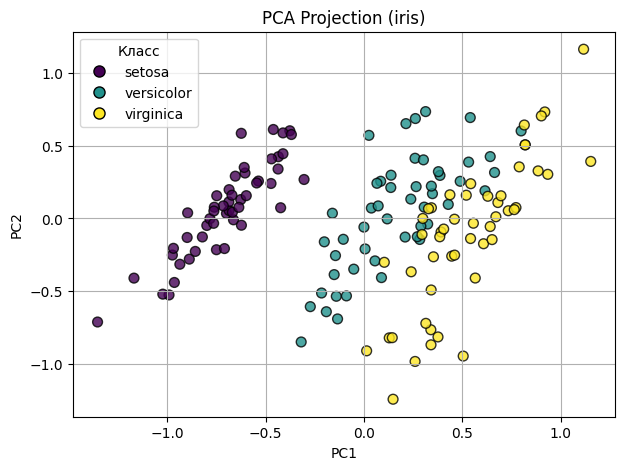

In [84]:
iris = load_iris()
print("\n=== PCA на датасете iris ===")
_, dim_iris = accuracy_score(iris.data, iris.target)
print(f"Размерность исходных данных: {dim_iris}")

X = iris.data
y = iris.target
class_names = iris.target_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_mat = [list(row) for row in X_train]
X_test_mat = [list(row) for row in X_test]
X_train_proj, gamma, k, sorted_eigenvectors, means = pca(X_train_mat, threshold=0.95)
X_test_centered = center_data(X_test_mat)
X_test_proj = find_k_main_projection(X_test_centered, sorted_eigenvectors, k)
y_pred_pca = knn_predict(X_train_proj, y_train, X_test_proj)
acc_pca = sum(yt == yp for yt, yp in zip(y_test, y_pred_pca)) / len(y_test)
print(f"Размерность после PCA: {len(X_train_proj[0])}")
print(f"Оптимальное число компонент (k): {k}")
print(f"Точность после применения PCA (iris): {acc_pca:.4f}")
print(f"Обусловленная дисперсия k компонент: {gamma}")

X_full_mat = [list(row) for row in X]
observations = add_noise_and_compare(X_full_mat)
print(f"Реакция датасета на шум: {observations['gamma']} - было, {observations['gamma_noisy']} - стало")
X_full_proj, _, _, _, _ = pca(X_full_mat, k=k, threshold=0.95)
fig = plot_pca_projection(X_full_proj, y=y, class_names=class_names, title="PCA Projection (iris)")
plt.show()